# Lab. 5: Iterated local Search and Simulated Annealing

## Introduction

#### <u>The goal of this lab is to compare the behavior of Iterated Local search (ILS) and Simulated Annealing on the knapsack 0/1 problem</u>

You'll have to implement five methods:

- *Iterated Local Search*:
  - perturbation(x, k). Try different implementation of the perturbation methods. (similar to the shake method in the previous lab)
  - local_search(f, x). Try different local search strategies (FirstImprovement or BestImprovement)
- *Simulated Annealing*:
  - random_neighbor(x, i). Select a random neighbor for the solution x by doing only a few changes
  - acceptance(x, eval_x, xp, eval_xp, T). Return the accepted solution (x or xp) and corresponding fitness.
  - update_temperature(T, alpha). Proceed with the update of the temperature parameter.
---

Getting started: The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

#### **The Knapsack 0/1 problem** is a combinatorial problem that works as follows.

We have a bag with limited capacity L, and we have a set of items  $I=\{i_1,...,i_N\}$  Each  $i_j$  has a given volume $w_{ij}$ and a value $v_{ij}$. The goal of the optimization problem is to fill the bag with a combination of items $S$ such that the combination maximizes the total value contained by the bag while complying with the constraint on the capacity.

In this version of the knapsack problem we can either discard or carry (at most 1) item. Thus, the search space is $\{0,1\}^{|I|}$ .

Since this is a maximization problem, we can turn it into a minimization problem by returning the opposite of the value. If a solution is not feasible (i.e., exceeds the maximum volume) the function will return a score of 0 (like an empty bag).


Assume
$$ N = \text{number of items} $$
$$ X = \{x_1, x_2, \dots, x_N\} = \text{set of items} $$
$$ v_i = \text{value of item } x_i $$
$$ w_i = \text{weight of item } x_i $$
$$ W = \text{maximum weight the knapsack can hold} $$


Then the 0/1 knapsack problem can be formulated as follows:

\begin{equation*}
  \begin{array}{lr}
    \text{maximize }   &S = \sum_{x_i \in X} v_i x_i \\
    \text{subject to } & \sum_{x_i \in X} w_i x_i \leq W \\
                       & x_i \in \{0, 1\} \forall x_i \in X \\
  \end{array}
\end{equation*}


In [1]:
import random
from copy import deepcopy
from dataclasses import dataclass
from itertools import combinations
from pprint import pformat, pprint
from typing import Literal

from matplotlib import pyplot as plt

Binary = Literal[0, 1]

In [2]:
@dataclass(frozen=True)
class Item:
    name: str
    value: int
    volume: int

    def __str__(self) -> str:
        return pformat({"name": self.name, "value": self.value, "volume": self.volume})


class Knapsack_0_1:

    def __init__(self):
        self.items = [
            Item("apple", 1, 2),
            Item("pear", 2, 2),
            Item("banana", 2, 2),
            Item("watermelon", 5, 10),
            Item("orange", 3, 2),
            Item("avocado", 3, 2),
            Item("blueberry", 3, 1),
            Item("coconut", 4, 3),
            Item("cherry", 2, 1),
            Item("apricot", 1, 1),
        ]
        self.BAG_CAPACITY = 10
        self.history: list[list[int]] = []
        self.values: list[int] = []

    def _get_value(self, solution: list[int]) -> int:
        cur_cap = self.BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self.items[i].value
                cur_cap -= self.items[i].volume
            if cur_cap < 0:
                return 0
        return -cur_val

    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

    def info(self, items_mask: list[int]) -> None:
        items = [self.items[i] for i in range(len(items_mask)) if items_mask[i] == 1]
        capacity = sum([i.volume for i in items])
        quantity = sum([i.value for i in items])
        pprint(
            {
                "items": items,
                "max capacity": self.BAG_CAPACITY,
                "achived capacity": capacity,
                "quantity": quantity,
            },
            sort_dicts=False,
        )

    def __call__(self, solution: list[int]) -> int:
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value

## Exercises

### Iterated Local Search
**Finish the implementation of the algorithm first**, then answer the question later on.

In [7]:
def iteratedLocalSearch(
    f: Knapsack_0_1,
    x0: list[int],
    ls_max: int,
    ls_type: Literal["first"] | Literal["best"],
):
    """
    Seeks for the minimum of the function by means of the Iterated local search algorithm.

    - f: the function to optimize
    - x0: the initial point
    - ls_max: the max number of local search
    """

    def perturbation(x: list[int], k: int) -> list[int]:
        """
        Implements the perturbation step for the ILS algorithm.

        - x: starting point
        - k: number of changes to be made

        Returns:
        - x': the random sampled from the neighborhood
        """
        # create a copy of x
        xp = deepcopy(x)

        # flip k random bits of xs
        indexes = random.sample(range(len(xp)), k)
        for i in indexes:
            xp[i] = 1 - xp[i]
        return xp

    def local_search(
        f: Knapsack_0_1, x: list[int], type: Literal["first"] | Literal["best"]
    ) -> list[int]:
        """
        Implements the local search step (e.g.: BestImprovement) for the ILS algorithm.

        - f: function to optimize
        - x: starting point

        Returns:
        - x': local optimum
        """
        xb = deepcopy(x)

        # generate all possible combinations that flip k bits
        combs = list(combinations(range(len(x)), len(x)))
        if type == "first":
            # perform a first-improvement local search
            for indexes in combs:
                xs = deepcopy(x)
                for i in indexes:
                    xs[i] = 1 - xs[i]
                if f(xs) < f(xb):
                    xb = xs
                    break
        elif type == "best":
            # perform a best-improvement local search
            for indexes in combs:
                xs = deepcopy(x)
                for i in indexes:
                    xs[i] = 1 - xs[i]
                if f(xs) < f(xb):
                    xb = xs
        else:
            raise ValueError("type must be 'first' or 'best'")

        return xb

    def acceptance_criterion(
        f: Knapsack_0_1, x: list[int], xs: list[int], k: int
    ) -> tuple[list[int], int]:
        if f(xs) < f(x):
            x = xs
            k = 1
        else:
            k += 1
        return x, k

    x = deepcopy(x0)
    best = x
    bestval = f(x)

    i = 0
    while i < ls_max:
        xp = perturbation(x, i)
        xs = local_search(f, xp, ls_type)
        x, i = acceptance_criterion(f, x, xs, i)

        # Store the best
        curval = f(x)
        if curval < bestval:
            bestval = curval
            best = x
    return best

#### Questions:
- how does the starting point influence the search process?
- how does the ls_max parameter affect the quality of the result?
- how does the perturbation of the solutions affect:
    - quality of the search?
    - velocity of the search?


{'items': [Item(name='pear', value=2, volume=2),
           Item(name='avocado', value=3, volume=2),
           Item(name='blueberry', value=3, volume=1),
           Item(name='coconut', value=4, volume=3),
           Item(name='cherry', value=2, volume=1),
           Item(name='apricot', value=1, volume=1)],
 'max capacity': 10,
 'achived capacity': 10,
 'quantity': 15}


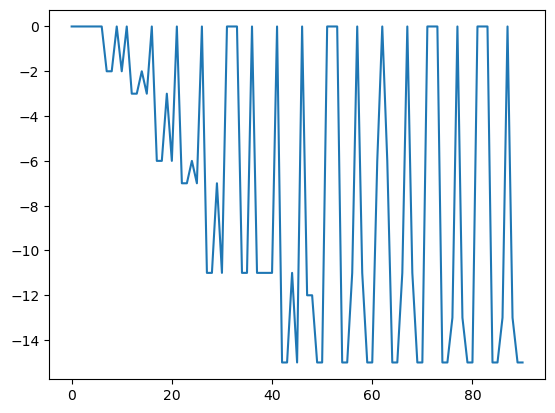

In [14]:
func = Knapsack_0_1()
solution = iteratedLocalSearch(func, [0] * len(func.items), 10, "first")
func.info(solution)
func.trend()

### Simulated Annealing
**Finish the implementation of the algorithm first**, then answer the question later on.

In [26]:
from math import e


def simulatedAnnealing(
    f: Knapsack_0_1, x0: list[int], iter: int, T: float, k: int, alpha: float
):
    """
    Seeks for the minimum of the function by means of the Simulated Annealing algorithm.

    - f: the function to optimize
    - x0: the initial point
    - iter: number of temperature update
    - T: Initial high temperature
    - k: Number of iterations at fixed temperature
    - alpha: cooling scheduling parameter
    """

    def random_neighbor(x: list[int], T: int) -> list[int]:
        """
        Generates a random neighbor for the solution x.

        - x: starting point
        - T: the current temperature

        Returns:
        - x': the random sample from the neighborhood
        """
        # create a copy of x
        xp = deepcopy(x)

        # we want to flip bits proportionally to the temperature resizing between 0 and the length of x
        # higher the temperature, higher the number of bits to flip
        # TODO: check if this is the correct way to do it
        n = int(T * len(x) / 100)

        # flip n random bits of xs
        indexes = random.sample(range(len(xp)), n)
        for i in indexes:
            xp[i] = 1 - xp[i]
        return xp

    def acceptance(
        x: list[int], eval_x: int, xp: list[int], eval_xp: int, T: float
    ) -> tuple[list[int], int]:
        """
        Returns the solution and fitness accepted between x and xp.

        - x: current solution
        - eval_x: eval of solution x
        - xp: new solution
        - eval_xp: eval of solution xp
        - T: temperature

        Returns:
        - x: new current solution
        - eval_x: eval of new solution x
        """
        if eval_xp < eval_x:
            return xp, eval_xp
        else:
            p = random.random()
            if p < e ** (-(eval_xp - eval_x) / T):
                return xp, eval_xp
        return x, eval_x

    def update_temperature(T: float, alpha: float) -> float:
        """
        Updates the temperature T.

        - T: temperature
        - alpha: cooling scheduling parameter

        Returns:
        - T: updated temperature
        """
        return T * alpha

    x = deepcopy(x0)
    eval_x = f(x)
    for _ in range(iter):
        for _ in range(k):
            eval_x = f(x)
            xp = random_neighbor(x, T)
            eval_xp = f(xp)
            x, eval_x = acceptance(x, eval_x, xp, eval_xp, T)
        T = update_temperature(T, alpha)  # type: ignore

    return x, eval_x

#### Questions:
- how does the starting point influence the search process?
- how does the initial temperature affect the quality of the result?
- how does the selection of the neighborhood affect:
    - quality of the search?
    - velocity of the search?
- How does the acceptance policy influence the search?
- How does the update of the temparture affect the search?


{'items': [Item(name='banana', value=2, volume=2),
           Item(name='avocado', value=3, volume=2),
           Item(name='coconut', value=4, volume=3),
           Item(name='cherry', value=2, volume=1)],
 'max capacity': 10,
 'achived capacity': 8,
 'quantity': 11}


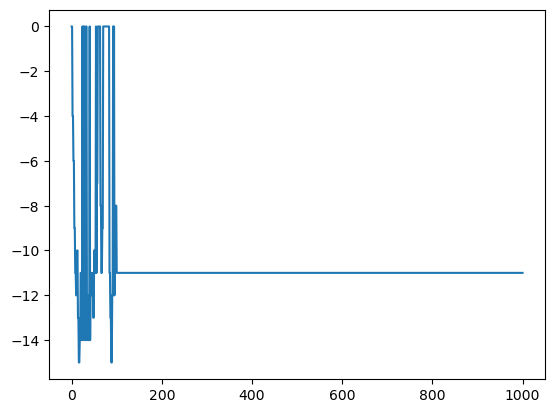

In [28]:
func = Knapsack_0_1()
x, eval_x = simulatedAnnealing(func, [0] * len(func.items), 10, 10, 50, 0.1)
func.info(x)
func.trend()

### Final questions:
Iterated local search, variable neighbor search, and simulated annealing are very similar optimization algorithms.
Considering what was seen in this lab and the previous one, answer these questions:
 - Is there a "more efficient" algorithm?
 - How do the different parameters affect the search, and do they affect the choice of one algorithm to respect the others?